In [800]:
# libraries import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import random

from feature_engine.timeseries.forecasting import LagFeatures
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.preprocessing.sequence import TimeseriesGenerator

# Data Cleaning

## Population dataset

In [801]:
# read in historical dataset

df_pop_hist = pd.read_csv('population_nsw.csv')
df_pop_hist

,time,population
0,Dec-2009,7101504
1,Mar-2010,7128356
2,Jun-2010,7144292
3,Sep-2010,7162726
4,Dec-2010,7179891
5,Mar-2011,7204737
6,Jun-2011,7218529
7,Sep-2011,7239528
8,Dec-2011,7258722
9,Mar-2012,7284982


In [802]:
# convert time col to datetime & filter to yearly freq

df_pop_hist['time'] = pd.to_datetime(df_pop_hist['time'],format='%b-%Y')
df_pop_hist['month'] = df_pop_hist['time'].dt.month
df_pop_hist['year'] = df_pop_hist['time'].dt.year
# df_pop_2 = df_pop[df_pop['month']==12]

In [803]:
df_pop_hist.head()

,time,population,month,year
0,2009-12-01,7101504,12,2009
1,2010-03-01,7128356,3,2010
2,2010-06-01,7144292,6,2010
3,2010-09-01,7162726,9,2010
4,2010-12-01,7179891,12,2010


Text(0, 0.5, 'population count')

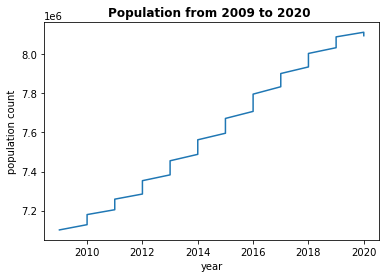

In [804]:
plt.plot(df_pop_hist['year'].to_numpy(),df_pop_hist['population'].to_numpy())
plt.title('Population from 2009 to 2020 ',fontweight='bold')
plt.xlabel('year')
plt.ylabel('population count')

In [805]:
df_pop_hist_yearly = df_pop_hist[df_pop_hist['month']==12]

In [806]:
# read in forecasted dataset

df_pop_fc = pd.read_csv('Projected population, New South Wales.csv')

In [807]:
# select relevant rows & cols

df_pop_fc = df_pop_fc[['Year','Medium series']].loc[:49]

In [808]:
df_pop_fc

,Year,Medium series
0,2022,"8,166,525"
1,2023,"8,323,889"
2,2024,"8,453,902"
3,2025,"8,580,341"
4,2026,"8,702,446"
5,2027,"8,820,393"
6,2028,"8,933,348"
7,2029,"9,041,818"
8,2030,"9,145,140"
9,2031,"9,243,603"


In [809]:
# convert col to integer

df_pop_fc['Medium series'] = df_pop_fc['Medium series'].apply(lambda x:int(x.replace(',','')))

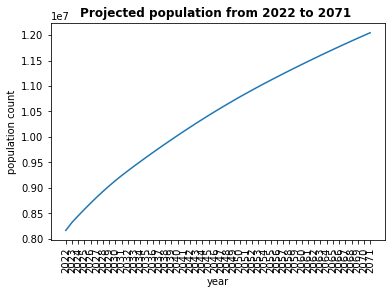

In [810]:
plt.plot(df_pop_fc['Year'].to_numpy(),df_pop_fc['Medium series'].to_numpy())
plt.title('Projected population from 2022 to 2071 ',fontweight='bold')
plt.xlabel('year')
plt.ylabel('population count')
plt.tick_params('x',labelrotation=90)

## Total Grid Demand dataset

In [811]:
# read in dataset

df_demand = pd.read_csv('Data/NSW/totaldemand_nsw.csv')
df_demand

,DATETIME,TOTALDEMAND,REGIONID
0,1/1/2010 0:00,8038.00,NSW1
1,1/1/2010 0:30,7809.31,NSW1
2,1/1/2010 1:00,7483.69,NSW1
3,1/1/2010 1:30,7117.23,NSW1
4,1/1/2010 2:00,6812.03,NSW1
...,...,...,...
196508,17/3/2021 22:00,7419.77,NSW1
196509,17/3/2021 22:30,7417.91,NSW1
196510,17/3/2021 23:00,7287.32,NSW1
196511,17/3/2021 23:30,7172.39,NSW1


In [812]:
# convert column to datetime

df_demand['DATETIME'] = pd.to_datetime(df_demand['DATETIME'],format='%d/%m/%Y %H:%M')
df_demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196513 entries, 0 to 196512
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   DATETIME     196513 non-null  datetime64[ns]
 1   TOTALDEMAND  196513 non-null  float64       
 2   REGIONID     196513 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 4.5+ MB


In [813]:
# extract datetime features

df_demand['year'] = df_demand['DATETIME'].dt.year
df_demand['month'] = df_demand['DATETIME'].dt.month
df_demand['dayofweek'] = df_demand['DATETIME'].dt.dayofweek
df_demand['hour'] = df_demand['DATETIME'].dt.hour
df_demand['day'] = df_demand['DATETIME'].dt.day
df_demand['min'] = df_demand['DATETIME'].dt.minute

Text(0, 0.5, 'MWh')

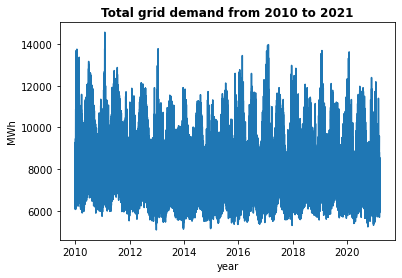

In [814]:
# plot of historical total demand

df_demand.index = df_demand['DATETIME']
plt.plot(df_demand['TOTALDEMAND'])
plt.title('Total grid demand from 2010 to 2021',fontweight='bold')
plt.xlabel('year')
plt.ylabel('MWh')
# plt.plot(df_demand[df_demand['year']==2016]['TOTALDEMAND'])

In [815]:
# filter to yearly freq

df_demand_yearly = df_demand[(df_demand['day']==30)&(df_demand['hour']==23)&(df_demand['min']==30)]
df_demand_yearly = df_demand_quart[df_demand_quart['month'].isin([12])]

In [816]:
df_demand_yearly

,DATETIME,TOTALDEMAND,REGIONID,year,month,dayofweek,hour,day,min
DATETIME,,,,,,,,,
2010-12-30 23:30:00,2010-12-30 23:30:00,7859.68,NSW1,2010,12,3,23,30,30
2011-12-30 23:30:00,2011-12-30 23:30:00,7476.96,NSW1,2011,12,4,23,30,30
2012-12-30 23:30:00,2012-12-30 23:30:00,6533.21,NSW1,2012,12,6,23,30,30
2013-12-30 23:30:00,2013-12-30 23:30:00,6892.83,NSW1,2013,12,0,23,30,30
2014-12-30 23:30:00,2014-12-30 23:30:00,7067.30,NSW1,2014,12,1,23,30,30
2015-12-30 23:30:00,2015-12-30 23:30:00,7066.52,NSW1,2015,12,2,23,30,30
2016-12-30 23:30:00,2016-12-30 23:30:00,8125.86,NSW1,2016,12,4,23,30,30
2017-12-30 23:30:00,2017-12-30 23:30:00,7304.04,NSW1,2017,12,5,23,30,30
2018-12-30 23:30:00,2018-12-30 23:30:00,7734.31,NSW1,2018,12,6,23,30,30


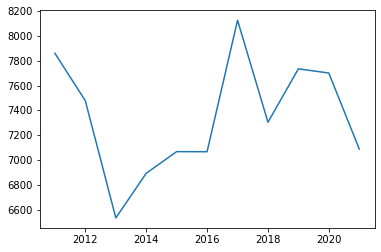

In [954]:
plt.plot(df_demand_yearly['TOTALDEMAND'])

## Solar panel dataset

In [817]:
# read in dataset for # of home solar installed

df_solar = pd.read_csv('Solar Install NSW.csv')
df_solar

,year,Number of units Installed each year,Cumulative number of solar Panels installed,"Average size the rooftop solar panel (each year, kW)",MW Addedd each year,Cumulative Total,Actual Total MW (allowing for 15% Efficiency)
0,2009,"14,008","14,008",2.0,28,28,4
1,2010,"69,988","83,996",2.2,154,182,27
2,2011,"80,272","164,268",2.4,193,375,56
3,2012,"53,961","218,229",2.6,140,515,77
4,2013,"33,998","252,227",2.9,99,614,92
5,2014,"37,210","289,437",3.0,112,725,109
6,2015,"33,478","322,915",3.0,100,826,124
7,2016,"29,498","352,413",3.2,94,920,138
8,2017,"43,253","395,666",3.5,151,"1,071",161
9,2018,"59,329","454,995",4.2,249,"1,321",198


In [818]:
# remove irrelevant columns

df_solar = df_solar[['year','Actual Total MW (allowing for 15% Efficiency)']]

Text(0, 0.5, 'MWh')

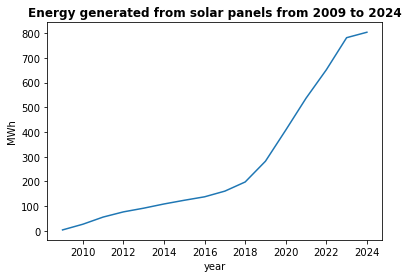

In [819]:
# plot of num of solar panel installed historically

plt.plot(df_solar['year'].to_numpy(),df_solar['Actual Total MW (allowing for 15% Efficiency)'].to_numpy())
plt.title('Energy generated from solar panels from 2009 to 2024',fontweight='bold')
plt.xlabel('year')
plt.ylabel('MWh')

In [1559]:
# merge with population df

# merged_solar_pop = df_solar.merge(df_pop_2,on='year')

In [2130]:
# # merge with total_grid_demand df

# merged_solar_demand = df_solar.merge(df_demand_filtered,on='year')

In [2132]:
# select relevant cols for modelling

# merged_solar_demand_2 = merged_solar_pop_demand[['year','Actual Total MW (allowing for 15% Efficiency)','TOTALDEMAND']]

In [2455]:
# merged_solar_demand_2.rename(columns={'Actual Total MW (allowing for 15% Efficiency)':'solar energy'},inplace=True)
# merged_solar_demand_2.head()

# Correlation of the 3 parameters

In [820]:
# merge solar energy, population & total demand datasets

merge_pop_demand = df_demand_yearly.merge(df_pop_hist_yearly,on=['year'],how='inner')
merge_all = merge_pop_demand.merge(df_solar,on=['year'],how='inner')
merge_all.rename(columns={'TOTALDEMAND':'grid_energy','Actual Total MW (allowing for 15% Efficiency)':'solar_energy'},inplace=True)

In [821]:
# correlation

merge_all[['grid_energy','population','solar_energy']].corr()

,grid_energy,population,solar_energy
grid_energy,1.000000,0.212893,0.034076
population,0.212893,1.000000,0.875866
solar_energy,0.034076,0.875866,1.000000


# Modelling

## Energy from Grid

In [958]:
# select relevant cols

merge_pop_demand = merge_pop_demand[['TOTALDEMAND','year','population']]

In [959]:
merge_pop_demand

,TOTALDEMAND,year,population
0,7859.68,2010,7179891
1,7476.96,2011,7258722
2,6533.21,2012,7353189
3,6892.83,2013,7454938
4,7067.30,2014,7562171
5,7066.52,2015,7671401
6,8125.86,2016,7795625
7,7304.04,2017,7900946
8,7734.31,2018,8003564
9,7700.67,2019,8088361


In [960]:
# create lag features

lag_transformer = LagFeatures(variables=['TOTALDEMAND'], periods=[1,2])
merge_pop_demand_lag = lag_transformer.fit_transform(merge_pop_demand)

In [961]:
# create X & y for modelling

merge_pop_demand_lag_2 = merge_pop_demand_lag.dropna()
X = merge_pop_demand_lag_2.drop(columns='TOTALDEMAND')
y = merge_pop_demand_lag_2['TOTALDEMAND']

In [962]:
# split into train & test

X_train = X.iloc[:int(np.round((0.8*len(X)))),:]
X_test = X.iloc[int(np.round((0.8*len(X)))):,:]
y_train = y[:int(np.round((0.8*len(X))))]
y_test = y[int(np.round((0.8*len(X)))):]

In [963]:
# setting seed

random.seed(100)
np.random.seed(100)
tf.random.set_seed(100)

In [964]:
# normalizing train set & reshape

sc_td_X = MinMaxScaler(feature_range = (0, 1))
X_train_scaled = sc_td_X.fit_transform(X_train)
X_train_scaled_2 = np.reshape(X_train_scaled,(X_train_scaled.shape[0],X_train_scaled.shape[1],1))

sc_td_y = MinMaxScaler(feature_range = (0, 1))
y_train_scaled = sc_td_y.fit_transform(np.reshape(y_train,(len(y_train),1)))

In [965]:
# normalizing test set & reshape

X_test_scaled = sc_td_X.transform(X_test)
X_test_scaled_2 = np.reshape(X_test_scaled,(X_test_scaled.shape[0],X_test_scaled.shape[1],1))

In [966]:
# # generate time series for modelling

# generator = TimeseriesGenerator(training_set_scaled,training_set_scaled,length=2,batch_size=1)
# g = TimeseriesGenerator(a,a,length=2,batch_size=1)

In [858]:
# lstm modelling + tuning # of lstm units

lstm = [2,4,8,16,32]
test_scores = []
pred_list = []

for i in lstm:
    regressor = Sequential()
    regressor.add(LSTM(units = i, return_sequences = False, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    regressor.fit(X_train_scaled_2, y_train_scaled,  batch_size= 2, epochs = 200)
    
    # predict on test set
    pred_inverse = regressor.predict(X_test_scaled_2)
    pred = sc_td_y.inverse_transform(pred_inverse)
    pred_list.append(pred)
    test_scores.append(mean_squared_error(pred,y_test,squared=False))

Epoch 1/200
4/4 [==============================] - 2s 5ms/step - loss: 0.2716
Epoch 2/200
4/4 [==============================] - 0s 6ms/step - loss: 0.2367
Epoch 3/200
4/4 [==============================] - 0s 8ms/step - loss: 0.2165
Epoch 4/200
4/4 [==============================] - 0s 8ms/step - loss: 0.2222
Epoch 5/200
4/4 [==============================] - 0s 8ms/step - loss: 0.2360
Epoch 6/200
4/4 [==============================] - 0s 7ms/step - loss: 0.1846
Epoch 7/200
4/4 [==============================] - 0s 5ms/step - loss: 0.2517
Epoch 8/200
4/4 [==============================] - 0s 7ms/step - loss: 0.2194
Epoch 9/200
4/4 [==============================] - 0s 7ms/step - loss: 0.2768
Epoch 10/200
4/4 [==============================] - 0s 6ms/step - loss: 0.1859
Epoch 11/200
4/4 [==============================] - 0s 5ms/step - loss: 0.2281
Epoch 12/200
4/4 [==============================] - 0s 6ms/step - loss: 0.2309
Epoch 13/200
4/4 [==============================] - 0s 5ms/st

4/4 [==============================] - 0s 3ms/step - loss: 0.0722
Epoch 105/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0684
Epoch 106/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0776
Epoch 107/200
4/4 [==============================] - 0s 3ms/step - loss: 0.1434
Epoch 108/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0715
Epoch 109/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0716
Epoch 110/200
4/4 [==============================] - 0s 3ms/step - loss: 0.1861
Epoch 111/200
4/4 [==============================] - 0s 3ms/step - loss: 0.1157
Epoch 112/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0544
Epoch 113/200
4/4 [==============================] - 0s 3ms/step - loss: 0.1158
Epoch 114/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0708
Epoch 115/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0524
Epoch 116/200
4/4 [==============================] - 0

4/4 [==============================] - 0s 5ms/step - loss: 0.2762
Epoch 7/200
4/4 [==============================] - 0s 4ms/step - loss: 0.2671
Epoch 8/200
4/4 [==============================] - 0s 3ms/step - loss: 0.2722
Epoch 9/200
4/4 [==============================] - 0s 3ms/step - loss: 0.2623
Epoch 10/200
4/4 [==============================] - 0s 3ms/step - loss: 0.2544
Epoch 11/200
4/4 [==============================] - 0s 3ms/step - loss: 0.2635
Epoch 12/200
4/4 [==============================] - 0s 3ms/step - loss: 0.2575
Epoch 13/200
4/4 [==============================] - 0s 7ms/step - loss: 0.2462
Epoch 14/200
4/4 [==============================] - 0s 3ms/step - loss: 0.2234
Epoch 15/200
4/4 [==============================] - 0s 3ms/step - loss: 0.2325
Epoch 16/200
4/4 [==============================] - 0s 3ms/step - loss: 0.2200
Epoch 17/200
4/4 [==============================] - 0s 3ms/step - loss: 0.2308
Epoch 18/200
4/4 [==============================] - 0s 3ms/step - lo

4/4 [==============================] - 0s 4ms/step - loss: 0.0954
Epoch 110/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0813
Epoch 111/200
4/4 [==============================] - 0s 3ms/step - loss: 0.1099
Epoch 112/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0874
Epoch 113/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0592
Epoch 114/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0879
Epoch 115/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0827
Epoch 116/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0911
Epoch 117/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0897
Epoch 118/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0898
Epoch 119/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0645
Epoch 120/200
4/4 [==============================] - 0s 3ms/step - loss: 0.1041
Epoch 121/200
4/4 [==============================] - 0

4/4 [==============================] - 0s 3ms/step - loss: 0.1378
Epoch 12/200
4/4 [==============================] - 0s 4ms/step - loss: 0.1154
Epoch 13/200
4/4 [==============================] - 0s 4ms/step - loss: 0.1229
Epoch 14/200
4/4 [==============================] - 0s 3ms/step - loss: 0.1629
Epoch 15/200
4/4 [==============================] - 0s 4ms/step - loss: 0.1197
Epoch 16/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0974
Epoch 17/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0827
Epoch 18/200
4/4 [==============================] - 0s 3ms/step - loss: 0.1112
Epoch 19/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0864
Epoch 20/200
4/4 [==============================] - 0s 3ms/step - loss: 0.1222
Epoch 21/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0866
Epoch 22/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0599
Epoch 23/200
4/4 [==============================] - 0s 3ms/step -

4/4 [==============================] - 0s 3ms/step - loss: 0.0951
Epoch 115/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0508
Epoch 116/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0484
Epoch 117/200
4/4 [==============================] - 0s 3ms/step - loss: 0.1112
Epoch 118/200
4/4 [==============================] - 0s 8ms/step - loss: 0.0455
Epoch 119/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0816
Epoch 120/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0646
Epoch 121/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0797
Epoch 122/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0581
Epoch 123/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0589
Epoch 124/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0911
Epoch 125/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0679
Epoch 126/200
4/4 [==============================] - 0

4/4 [==============================] - 0s 3ms/step - loss: 0.1092
Epoch 17/200
4/4 [==============================] - 0s 4ms/step - loss: 0.1088
Epoch 18/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0807
Epoch 19/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0859
Epoch 20/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0911
Epoch 21/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0641
Epoch 22/200
4/4 [==============================] - 0s 3ms/step - loss: 0.1125
Epoch 23/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0662
Epoch 24/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0626
Epoch 25/200
4/4 [==============================] - 0s 3ms/step - loss: 0.1100
Epoch 26/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0723
Epoch 27/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0627
Epoch 28/200
4/4 [==============================] - 0s 3ms/step -

4/4 [==============================] - 0s 3ms/step - loss: 0.0528
Epoch 120/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0541
Epoch 121/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0654
Epoch 122/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0412
Epoch 123/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0373
Epoch 124/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0360
Epoch 125/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0611
Epoch 126/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0788
Epoch 127/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0546
Epoch 128/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0267
Epoch 129/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0561
Epoch 130/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0518
Epoch 131/200
4/4 [==============================] - 0

Epoch 22/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0725
Epoch 23/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0837
Epoch 24/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0706
Epoch 25/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0472
Epoch 26/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0613
Epoch 27/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0442
Epoch 28/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0500
Epoch 29/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0536
Epoch 30/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0355
Epoch 31/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0671
Epoch 32/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0540
Epoch 33/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0670
Epoch 34/200
4/4 [==============================] - 

4/4 [==============================] - 0s 3ms/step - loss: 0.0385
Epoch 126/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0402
Epoch 127/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0368
Epoch 128/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0484
Epoch 129/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0530
Epoch 130/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0427
Epoch 131/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0400
Epoch 132/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0476
Epoch 133/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0509
Epoch 134/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0322
Epoch 135/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0381
Epoch 136/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0554
Epoch 137/200
4/4 [==============================] - 0

In [859]:
test_scores

[292.9325003518566,
 425.00533374941506,
 505.22671170373775,
 559.9379850090681,
 607.9694227926833]

Text(0, 0.5, 'rmse')

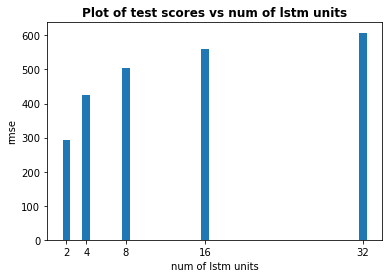

In [860]:
plt.bar(lstm,test_scores)
plt.xticks(lstm,lstm)
plt.title('Plot of test scores vs num of lstm units',fontweight='bold')
plt.xlabel('num of lstm units')
plt.ylabel('rmse')

([<matplotlib.axis.XTick at 0x7fd0ff9b6a30>,
 [Text(0, 0, '2019'), Text(0, 0, '2020')])

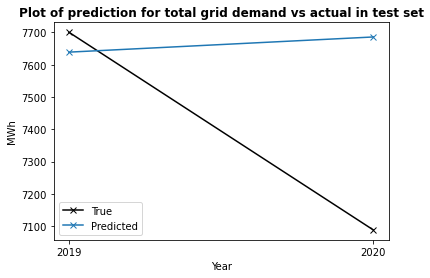

In [861]:
xlabel = merge_pop_demand['year'][-2:].to_numpy()
plt.plot(xlabel,y_test.to_numpy(),c='black',marker='x',label='True')
plt.plot(xlabel,pred_list[1],label='Predicted',marker='x')
plt.legend()
plt.title('Plot of prediction for total grid demand vs actual in test set',fontweight='bold')
plt.xlabel('Year')
plt.ylabel('MWh')
plt.xticks(xlabel,[2019,2020])

In [864]:
# training model on entire dataset

sc_td_X_final = MinMaxScaler(feature_range = (0, 1))
X_td_scaled = sc_td_X_final.fit_transform(X)
X_td_scaled_2 = np.reshape(X_td_scaled,(X_td_scaled.shape[0],X_td_scaled.shape[1],1))

sc_td_y_final = MinMaxScaler(feature_range = (0, 1))
y_td_scaled = sc_td_y_final.fit_transform(np.reshape(y,(len(y),1)))

regressor_td_final = Sequential()
regressor_td_final.add(LSTM(units = 2, return_sequences = False, input_shape = (X.shape[1], 1)))
regressor_td_final.add(Dropout(0.2))
regressor_td_final.add(Dense(units = 1))
regressor_td_final.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor_td_final.fit(X_td_scaled_2, y_td_scaled,  batch_size= 2, epochs = 100)

Epoch 1/100
5/5 [==============================] - 2s 4ms/step - loss: 0.2725
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 0.1930
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.2311
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 0.3003
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 0.1394
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.1636
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.1754
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.1592
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.1959
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.1202
Epoch 11/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0868
Epoch 12/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0982
Epoch 13/100
5/5 [==============================] - 0s 5ms/st

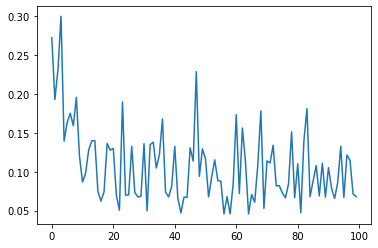

In [865]:
plt.plot(regressor_td_final.history.history['loss'])

In [150]:
# # modelling using XGB + hyperparemeter tuning

# xgb = XGBRegressor()
# params = {'gamma':[0.1,1,10,100],'alpha':[0.1,1,10,100]}

# gs = GridSearchCV(xgb,params,scoring='neg_root_mean_squared_error',cv=TimeSeriesSplit(3))
# gs.fit(X_train.to_numpy(),y_train)

In [151]:
# # select best mean CV test score & params

# print(gs.best_params_)
# print(gs.best_score_)

In [152]:
# # obtain rmse on test set with best params

# xgb_totaldemand = XGBRegressor(alpha=gs.best_params_['alpha'],gamma=gs.best_params_['gamma'])
# xgb_totaldemand.fit(X_train.to_numpy(),y_train)
# pred = xgb_totaldemand.predict(X_test)
# mean_squared_error(y_test,pred,squared=False)

In [71]:
# # obtain feature importance

# df_feat_impt = pd.DataFrame(xgb_totaldemand.feature_importances_,columns=['feat_impt'])
# df_feat_impt['feature_name'] = X_test.columns
# df_feat_impt.sort_values(by='feat_impt',ascending=False,inplace=True)

In [153]:
# plt.bar(df_feat_impt['feature_name'],df_feat_impt['feat_impt'])
# plt.tick_params('x',labelrotation=90)
# plt.title('Barplot of feature importance',fontweight='bold')
# plt.xlabel('features')
# plt.ylabel('feature importance (scaled between 0 to 1)')

In [154]:
# # remodel with only 'TOTALDEMAND_lag_1' & 'hour'

# df_demand_lag_2 = df_demand_lag.dropna()
# X = df_demand_lag_2[['TOTALDEMAND_lag_1','hour']]
# y = df_demand_lag_2['TOTALDEMAND']

# X_train = X.iloc[:int(np.round((0.8*len(X)))),:]
# X_test = X.iloc[int(np.round((0.8*len(X)))):,:]
# y_train = y[:int(np.round((0.8*len(X))))]
# y_test = y[int(np.round((0.8*len(X)))):]

# xgb_final = XGBRegressor()
# params = {'gamma':[0.1,1,10,100],'alpha':[0.1,1,10,100]}

# gs_final = GridSearchCV(xgb_final,params,scoring='neg_root_mean_squared_error',cv=TimeSeriesSplit(3))
# gs_final.fit(X_train.to_numpy(),y_train)

# print(gs_final.best_params_)
# print(gs_final.best_score_)

# xgb_final_test = XGBRegressor(alpha=gs_final.best_params_['alpha'],gamma=gs_final.best_params_['gamma'])
# xgb_final_test.fit(X_train.to_numpy(),y_train)
# pred_final_test = xgb_final_test.predict(X_test)
# mean_squared_error(y_test,pred_final_test,squared=False)

In [209]:
# plt.plot(y_test.index.to_numpy(),y_test.to_numpy(),c='black',label='True')
# plt.plot(y_test.index.to_numpy(),pred,c='red',alpha=0.5,label='Predicted')
# plt.title('Plot of prediction for electricity demand vs actual in test set',fontweight='bold')
# plt.xlabel('year')
# plt.ylabel('MWh')
# plt.legend()
# plt.tick_params('x',labelrotation=90)

In [210]:
# plt.plot(y_test.index.to_numpy(),y_test.to_numpy(),c='black',label='True')
# plt.plot(y_test.index.to_numpy(),pred,c='red',alpha=0.5,label='Predicted')
# plt.title('Plot of prediction for electricity demand vs actual in test set (ZOOM IN)',fontweight='bold')
# plt.xlabel('year')
# plt.ylabel('MWh')
# plt.legend()
# plt.tick_params('x',labelrotation=90)
# plt.xlim(pd.Timestamp(2021,1,1),pd.Timestamp(2021,3,1))

## Modelling: Energy from solar panel

In [866]:
merge_solar_pop = df_solar.merge(df_pop_hist_yearly,on='year',how='inner')

In [867]:
merge_solar_pop

,year,Actual Total MW (allowing for 15% Efficiency),time,population,month
0,2009,4,2009-12-01,7101504,12
1,2010,27,2010-12-01,7179891,12
2,2011,56,2011-12-01,7258722,12
3,2012,77,2012-12-01,7353189,12
4,2013,92,2013-12-01,7454938,12
5,2014,109,2014-12-01,7562171,12
6,2015,124,2015-12-01,7671401,12
7,2016,138,2016-12-01,7795625,12
8,2017,161,2017-12-01,7900946,12
9,2018,198,2018-12-01,8003564,12


In [868]:
# create lag features

# lag_transformer = LagFeatures(variables=['solar energy'], periods=[1,2])
# df_solar_lag = lag_transformer.fit_transform(merged_solar_demand_2)
lag_transformer = LagFeatures(variables=['Actual Total MW (allowing for 15% Efficiency)'], periods=[1,2])
df_solar_lag = lag_transformer.fit_transform(merge_solar_pop)

In [869]:
# split into X & y

# df_solar_lag.dropna(inplace=True)
# X = df_solar_lag[['year','total_demand', 'solar energy_lag_1',
#        'solar energy_lag_2']]
# y = df_solar_lag['solar energy']

df_solar_lag.dropna(inplace=True)
X = df_solar_lag[['year','population',
       'Actual Total MW (allowing for 15% Efficiency)_lag_1',
       'Actual Total MW (allowing for 15% Efficiency)_lag_2']]
y = df_solar_lag['Actual Total MW (allowing for 15% Efficiency)']

In [870]:
# split into train & test

X_train = X.iloc[:int(np.round((0.8*len(X)))),:]
X_test = X.iloc[int(np.round((0.8*len(X)))):,:]
y_train = y[:int(np.round((0.8*len(X))))]
y_test = y[int(np.round((0.8*len(X)))):]

In [871]:
# normalizing train set & reshape

sc_X = MinMaxScaler(feature_range = (0, 1))
X_train_scaled = sc_X.fit_transform(X_train)
X_train_scaled_2 = np.reshape(X_train_scaled,(X_train_scaled.shape[0],X_train_scaled.shape[1],1))

sc_y = MinMaxScaler(feature_range = (0, 1))
y_train_scaled = sc_y.fit_transform(np.reshape(y_train,(len(y_train),1)))

In [872]:
# normalizing test set & reshape

X_test_scaled = sc_X.transform(X_test)
X_test_scaled_2 = np.reshape(X_test_scaled,(X_test_scaled.shape[0],X_test_scaled.shape[1],1))

In [873]:
# # generate time series for modelling

# generator = TimeseriesGenerator(training_set_scaled,training_set_scaled,length=2,batch_size=1)
# g = TimeseriesGenerator(a,a,length=2,batch_size=1)

In [877]:
# lstm modelling + tuning # of epoch

lstm = [8,16,32,64,128]
test_scores = []
pred_list = []

for i in lstm:
    regressor = Sequential()
    regressor.add(LSTM(units = i, return_sequences = False, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    regressor.fit(X_train_scaled_2, y_train_scaled,  batch_size= 2, epochs = 200)
    
    # predict on test set
    pred_inverse = regressor.predict(X_test_scaled_2)
    pred = sc_y.inverse_transform(pred_inverse)
    pred_list.append(pred)
    test_scores.append(mean_squared_error(pred,y_test,squared=False))

Epoch 1/200
4/4 [==============================] - 1s 3ms/step - loss: 0.2436
Epoch 2/200
4/4 [==============================] - 0s 4ms/step - loss: 0.1806
Epoch 3/200
4/4 [==============================] - 0s 3ms/step - loss: 0.1630
Epoch 4/200
4/4 [==============================] - 0s 3ms/step - loss: 0.1300
Epoch 5/200
4/4 [==============================] - 0s 4ms/step - loss: 0.1312
Epoch 6/200
4/4 [==============================] - 0s 4ms/step - loss: 0.1086
Epoch 7/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0961
Epoch 8/200
4/4 [==============================] - 0s 3ms/step - loss: 0.1083
Epoch 9/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0960
Epoch 10/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0691
Epoch 11/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0733
Epoch 12/200
4/4 [==============================] - 0s 4ms/step - loss: 0.1286
Epoch 13/200
4/4 [==============================] - 0s 4ms/st

4/4 [==============================] - 0s 5ms/step - loss: 0.0303
Epoch 105/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0172
Epoch 106/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 107/200
4/4 [==============================] - 0s 7ms/step - loss: 0.0099
Epoch 108/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 109/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 110/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0280
Epoch 111/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0160
Epoch 112/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 113/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 114/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 115/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 116/200
4/4 [==============================] - 0

4/4 [==============================] - 0s 4ms/step - loss: 0.2136
Epoch 7/200
4/4 [==============================] - 0s 3ms/step - loss: 0.2257
Epoch 8/200
4/4 [==============================] - 0s 3ms/step - loss: 0.1506
Epoch 9/200
4/4 [==============================] - 0s 3ms/step - loss: 0.1285
Epoch 10/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0894
Epoch 11/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0917
Epoch 12/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0812
Epoch 13/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0840
Epoch 14/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0765
Epoch 15/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0649
Epoch 16/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0342
Epoch 17/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0277
Epoch 18/200
4/4 [==============================] - 0s 4ms/step - lo

4/4 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 110/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 111/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 112/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 113/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 114/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 115/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 116/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 117/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 118/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 119/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 120/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 121/200
4/4 [==============================] - 0

4/4 [==============================] - 0s 3ms/step - loss: 0.0359
Epoch 12/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0173
Epoch 13/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0230
Epoch 14/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 15/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0327
Epoch 16/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0207
Epoch 17/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0199
Epoch 18/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0167
Epoch 19/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0319
Epoch 20/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0079
Epoch 21/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 22/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0192
Epoch 23/200
4/4 [==============================] - 0s 3ms/step -

4/4 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 115/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 116/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 117/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 118/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 119/200
4/4 [==============================] - 0s 7ms/step - loss: 0.0045
Epoch 120/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 121/200
4/4 [==============================] - 0s 3ms/step - loss: 8.8293e-04
Epoch 122/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 123/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 124/200
4/4 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 125/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 126/200
4/4 [==============================]

4/4 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 17/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 18/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 19/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 20/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0077
Epoch 21/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 22/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 23/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 24/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 25/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 26/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 27/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 28/200
4/4 [==============================] - 0s 3ms/step -

4/4 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 120/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 121/200
4/4 [==============================] - 0s 2ms/step - loss: 4.8724e-04
Epoch 122/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 123/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 124/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 125/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 126/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 127/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 128/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 129/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 130/200
4/4 [==============================] - 0s 3ms/step - loss: 1.7977e-04
Epoch 131/200
4/4 [===========================

4/4 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 22/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 23/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 24/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 25/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 26/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 27/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 28/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 29/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 30/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 31/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 32/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 33/200
4/4 [==============================] - 0s 3ms/step -

4/4 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 124/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 125/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 126/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 127/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 128/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 129/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 130/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 131/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 132/200
4/4 [==============================] - 0s 4ms/step - loss: 1.5673e-04
Epoch 133/200
4/4 [==============================] - 0s 4ms/step - loss: 9.3506e-04
Epoch 134/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 135/200
4/4 [===========================

In [878]:
test_scores

[140.69297118583071,
 122.42277353411934,
 104.2546900477913,
 97.98204470010728,
 106.22070287376947]

Text(0, 0.5, 'rmse')

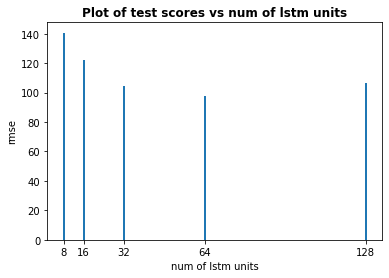

In [879]:
plt.bar(lstm,test_scores)
plt.xticks(lstm,lstm)
plt.title('Plot of test scores vs num of lstm units',fontweight='bold')
plt.xlabel('num of lstm units')
plt.ylabel('rmse')

Text(0, 0.5, 'MWh')

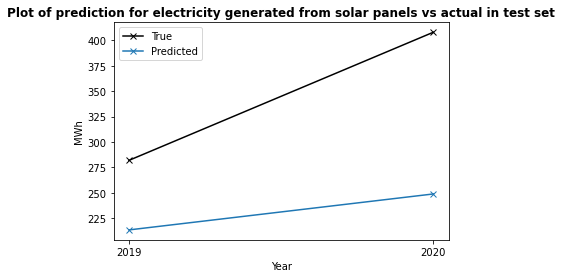

In [880]:
plt.plot([2019,2020],y_test.to_numpy(),c='black',marker='x',label='True')
plt.plot([2019,2020],pred_list[1],label='Predicted',marker='x')
plt.xticks([2019,2020],[2019,2020])
plt.legend()
plt.title('Plot of prediction for electricity generated from solar panels vs actual in test set',fontweight='bold')
plt.xlabel('Year')
plt.ylabel('MWh')

In [760]:
# plt.plot(regressor.history.history['loss'])

In [883]:
# training model on entire dataset

sc_sp_final_X = MinMaxScaler(feature_range = (0, 1))
X_sp_scaled = sc_sp_final_X.fit_transform(X)
X_sp_scaled_2 = np.reshape(X_sp_scaled,(X_sp_scaled.shape[0],X_sp_scaled.shape[1],1))

sc_sp_final_y = MinMaxScaler(feature_range = (0, 1))
y_sp_scaled = sc_sp_final_y.fit_transform(np.reshape(y,(len(y),1)))

regressor_final = Sequential()
regressor_final.add(LSTM(units = 64, return_sequences = False, input_shape = (X_train.shape[1], 1)))
regressor_final.add(Dropout(0.2))
regressor_final.add(Dense(units = 1))
regressor_final.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor_final.fit(X_sp_scaled_2, y_sp_scaled,  batch_size= 2, epochs = 100)

Epoch 1/100
5/5 [==============================] - 1s 4ms/step - loss: 0.1432
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 0.1249
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0710
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0599
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0293
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0427
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0272
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0281
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0434
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0268
Epoch 11/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0294
Epoch 12/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0216
Epoch 13/100
5/5 [==============================] - 0s 4ms/st

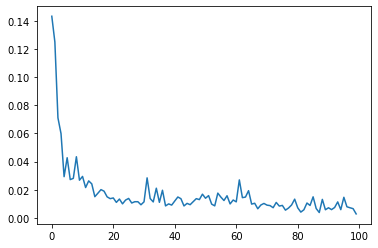

In [884]:
plt.plot(regressor_final.history.history['loss'])

## Forecasting into Future: Total electricity demand

In [897]:
# create dataframe for forecasting

df_forecast_td = pd.DataFrame(range(2019,2071),columns=['year'])
df_forecast_td['population'] = 0
df_forecast_td['TOTALDEMAND'] = 0
df_forecast_td.iloc[0,2] = 7700.67
df_forecast_td.iloc[1,2] = 7088.15
df_forecast_td.loc[2:,'population'] = df_pop_fc['Medium series'].to_numpy()

# create lag features
lag_transformer = LagFeatures(variables=['TOTALDEMAND'], periods=[1,2])
df_forecast_td_lag = lag_transformer.fit_transform(df_forecast_td)
df_forecast_td_lag.dropna(inplace=True)

In [899]:
# forecasting

b = []

for i in df_forecast_td_lag.index:
    
    input_scaled = sc_td_X_final.transform(np.reshape(df_forecast_td_lag[['year','population','TOTALDEMAND_lag_1',
       'TOTALDEMAND_lag_2']].loc[i],(1,4)))
    pred_td = regressor_td_final.predict(np.reshape(input_scaled,(1,4,1)))
    output = sc_td_y_final.inverse_transform(np.reshape(pred_td,(1,1)))
    b.append(output[0][0])
    df_forecast_td.loc[i,'TOTALDEMAND'] = output
    df_forecast_td_lag = lag_transformer.fit_transform(df_forecast_td)

/Users/leo_r/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/leo_r/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/leo_r/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/leo_r/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/leo_r/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/leo_r/opt/anaconda3/lib/python3.8/site-pack

/Users/leo_r/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/leo_r/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/leo_r/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/leo_r/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/leo_r/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [901]:
df_forecast_td

,year,population,TOTALDEMAND
0,2019,0,7700.670000
1,2020,0,7088.150000
2,2021,8166525,7334.413574
3,2022,8323889,7363.938965
4,2023,8453902,7381.816895
5,2024,8580341,7394.614258
6,2025,8702446,7405.055664
7,2026,8820393,7413.768555
8,2027,8933348,7421.075684
9,2028,9041818,7427.252930


Text(0.5, 0, 'year')

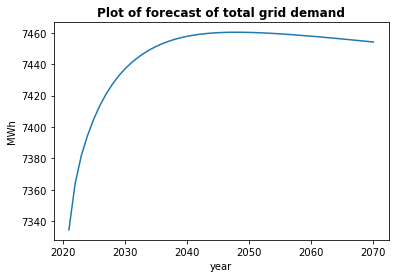

In [902]:
plt.plot(df_forecast_td['year'][2:].to_numpy(),df_forecast_td['TOTALDEMAND'][2:].to_numpy())
plt.title('Plot of forecast of total grid demand',fontweight='bold')
plt.ylabel('MWh')
plt.xlabel('year')
# plt.tick_params('x',labelrotation=90)

In [2178]:
# # create dataframe for forecasting

# df_forecast = pd.DataFrame(pd.date_range(start='2021-03-17 23:30',end='2030-12-31 23:30',freq='30min'),columns=['Datetime'])
# df_forecast['total_demand'] = 0
# df_forecast.iloc[0,1] = 7172.39
# df_forecast.iloc[1,1] = 7094.51

# df_forecast['year'] = df_forecast['Datetime'].dt.year
# df_forecast['month'] = df_forecast['Datetime'].dt.month
# df_forecast['dayofweek'] = df_forecast['Datetime'].dt.dayofweek
# df_forecast['hour'] = df_forecast['Datetime'].dt.hour

# # create lag features
# lag_transformer = LagFeatures(variables=['total_demand'], periods=[1,2])
# df_forecast_lag = lag_transformer.fit_transform(df_forecast)

In [215]:
# # forecasting

# a = []

# for i in df_forecast_lag.index[2:]:
    
#     pred = xgb_totaldemand.predict(np.reshape(df_forecast_lag[['year', 'month', 'dayofweek', 'hour',
#        'total_demand_lag_1', 'total_demand_lag_2']].loc[i],(1,6)))[0]
    
#     a.append(pred)
#     df_forecast.loc[i,'total_demand'] = pred
#     df_forecast_lag = lag_transformer.fit_transform(df_forecast)

In [216]:
# plt.plot(df_forecast_lag['total_demand'])

## Forecasting into Future: Electricity from solar panel

In [2467]:
# merged_solar_demand_2.rename(columns={'TOTALDEMAND':'total_demand'},inplace=True)
# merged_solar_demand_2.tail()

In [2468]:
# merged_solar_demand_3 = merged_solar_demand_2.merge(df_forecast_2030_2,on='year',how='outer')
# merged_solar_demand_3

In [2329]:
# merged_solar_demand_3.loc[11:,'total_demand_x'] = merged_solar_demand_3.loc[11:,'total_demand_y']
# merged_solar_demand_3 = merged_solar_demand_3[['year','solar energy','total_demand_x']]

In [2469]:
# merged_solar_demand_4 = merged_solar_demand_3.loc[9:,:]
# merged_solar_demand_4.loc[11:19,'solar energy'] = 0
# merged_solar_demand_4

In [2331]:
# create dataframe for forecasting

# df_forecast_sp = pd.DataFrame(range(2019,2029),columns=['year'])
# df_forecast_sp['energy'] = 0
# df_forecast_sp.iloc[0,1] = 408
# df_forecast_sp.iloc[1,1] = 537
# df_forecast_sp['']

# # create lag features
# lag_transformer = LagFeatures(variables=['solar energy'], periods=[1,2])
# df_forecast_sp_lag = lag_transformer.fit_transform(merged_solar_demand_4)

In [903]:
# create dataframe for forecasting

df_forecast_sp = pd.DataFrame(range(2019,2071),columns=['year'])
df_forecast_sp['solar_energy'] = 0
df_forecast_sp['population'] = 0
df_forecast_sp.iloc[0,1] = 282
df_forecast_sp.iloc[1,1] = 408
df_forecast_sp.loc[2:,'population'] = df_pop_fc['Medium series'].to_numpy()

# create lag features
lag_transformer = LagFeatures(variables=['solar_energy'], periods=[1,2])
df_forecast_sp_lag = lag_transformer.fit_transform(df_forecast_sp)
df_forecast_sp_lag.dropna(inplace=True)

In [904]:
# forecasting

a = []

for i in df_forecast_sp_lag.index:
    
    input_scaled = sc_sp_final_X.transform(np.reshape(df_forecast_sp_lag[['year','population','solar_energy_lag_1',
       'solar_energy_lag_2']].loc[i],(1,4)))
    pred_sp = regressor_final.predict(np.reshape(input_scaled,(1,4,1)))
    output = sc_sp_final_y.inverse_transform(np.reshape(pred_sp,(1,1)))
    a.append(output[0][0])
    df_forecast_sp.loc[i,'solar_energy'] = output
    df_forecast_sp_lag = lag_transformer.fit_transform(df_forecast_sp)

/Users/leo_r/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/leo_r/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/leo_r/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/leo_r/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/leo_r/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/leo_r/opt/anaconda3/lib/python3.8/site-pack

/Users/leo_r/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/leo_r/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/leo_r/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/leo_r/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Text(0.5, 0, 'year')

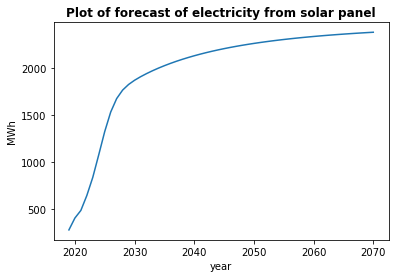

In [905]:
plt.plot(df_forecast_sp['year'].to_numpy(),df_forecast_sp['solar_energy'].to_numpy())
plt.title('Plot of forecast of electricity from solar panel',fontweight='bold')
plt.ylabel('MWh')
plt.xlabel('year')
# plt.tick_params('x',labelrotation=90)

In [939]:
# merging historical with forecasted datasets

merge_solar_demand_2 = merge_solar_demand[['year','Actual Total MW (allowing for 15% Efficiency)','TOTALDEMAND']]
merge_solar_demand_2.rename(columns={'Actual Total MW (allowing for 15% Efficiency)':'solar_energy'},inplace=True)
merge_solar_demand_3 = pd.concat([merge_solar_demand_2,df_forecast_sp.loc[2:,]],ignore_index=True)
merge_solar_demand_3.loc[11:,'TOTALDEMAND'] = df_forecast_td.loc[2:,'TOTALDEMAND'].to_numpy()

<ipython-input-939-83df8ddadc3f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_solar_demand_2.rename(columns={'Actual Total MW (allowing for 15% Efficiency)':'solar_energy'},inplace=True)


Text(0.5, 0, 'year')

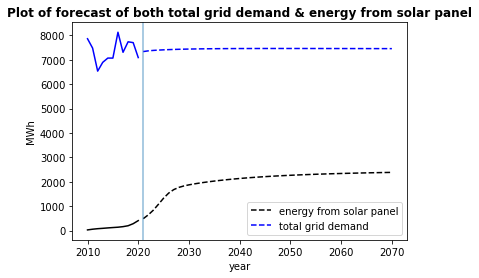

In [957]:
plt.plot(merge_solar_demand_3['year'][:11].to_numpy(),merge_solar_demand_3['solar_energy'][:11].to_numpy(),c='black')
plt.plot(merge_solar_demand_3['year'][11:].to_numpy(),merge_solar_demand_3['solar_energy'][11:].to_numpy(),c='black',linestyle='--',label='energy from solar panel')
plt.axvline(2021,alpha=0.5)
plt.plot(merge_solar_demand_3['year'][:11].to_numpy(),merge_solar_demand_3['TOTALDEMAND'][:11].to_numpy(),c='blue')
plt.plot(merge_solar_demand_3['year'][11:].to_numpy(),merge_solar_demand_3['TOTALDEMAND'][11:].to_numpy(),c='blue',linestyle='--',label='total grid demand')

plt.title('Plot of forecast of both total grid demand & energy from solar panel',fontweight='bold')
plt.legend()
plt.ylabel('MWh')
plt.xlabel('year')

Text(0.5, 0, 'year')

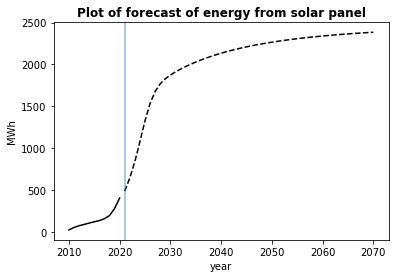

In [956]:
plt.plot(merge_solar_demand_3['year'][:11].to_numpy(),merge_solar_demand_3['solar_energy'][:11].to_numpy(),c='black')
plt.plot(merge_solar_demand_3['year'][11:].to_numpy(),merge_solar_demand_3['solar_energy'][11:].to_numpy(),c='black',linestyle='--',label='energy from solar panel')
plt.title('Plot of forecast of electricity from solar panel',fontweight='bold')
plt.axvline(2021,alpha=0.5)
plt.title('Plot of forecast of energy from solar panel',fontweight='bold')
plt.ylabel('MWh')
plt.xlabel('year')

Text(0.5, 0, 'year')

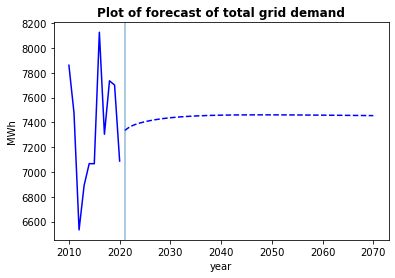

In [955]:
plt.plot(merge_solar_demand_3['year'][11:].to_numpy(),merge_solar_demand_3['TOTALDEMAND'][11:].to_numpy(),c='blue',linestyle='--',label='total grid demand')
plt.plot(merge_solar_demand_3['year'][:11].to_numpy(),merge_solar_demand_3['TOTALDEMAND'][:11].to_numpy(),c='blue')
plt.axvline(2021,alpha=0.5)
plt.title('Plot of forecast of total grid demand',fontweight='bold')
plt.ylabel('MWh')
plt.xlabel('year')